Introduction
=========

A first attempt for assignment


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import datetime

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

print('TF version:', tf.__version__)
print('TFP version:', tfp.__version__)

from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop

2023-11-14 22:00:44.129936: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 22:00:44.306855: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-14 22:00:45.167846: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /data/share/soft/anaconda/anaconda3/envs/tf/lib/libfabric::/usr/local/cuda/lib64
2023-11-14 22:00:45.167963: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvin

TF version: 2.10.1
TFP version: 0.18.0


In [3]:
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
# from probabilistic_models_archive.prior import sg_prior, gmm_prior
# from probabilistic_models_archive.posterior import posterior
# from probabilistic_models_archive.utils import nll

In [5]:
# %matplotlib inline

In [6]:
data = pd.read_csv('../data/raw/smedebtsu.csv')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     84 non-null     object 
 1   Day      84 non-null     int64  
 2   Month    84 non-null     int64  
 3   Year     84 non-null     int64  
 4   LenderA  84 non-null     float64
 5   LenderB  84 non-null     float64
 6   LenderC  84 non-null     float64
 7   LenderD  84 non-null     int64  
 8   LenderE  84 non-null     float64
 9   LenderF  84 non-null     float64
 10  LenderG  84 non-null     float64
 11  LenderH  84 non-null     float64
 12  LenderI  84 non-null     float64
 13  LenderJ  84 non-null     float64
 14  LenderK  84 non-null     float64
 15  totalU   84 non-null     float64
dtypes: float64(11), int64(4), object(1)
memory usage: 10.6+ KB


### clean date format

In [8]:
def inspect_date_format(df):
    """ identifying rows with wrong date formatting """
    
    m = pd.to_datetime(df['Date'], format="%d/%m/%Y", errors='coerce').isna()
    wrong_dates = df.loc[m, 'Date'].unique().tolist()
    print("Detected wrong date format:", wrong_dates)
    
    # pinpoint the rows with such incorrect dates
    for i in wrong_dates:
        print(f"row index with wrong dates '{i}' ==> {df[df['Date'] == i].index}")

In [9]:
inspect_date_format(data)

Detected wrong date format: ['04/042022', '02/052022']
row index with wrong dates '04/042022' ==> Index([73], dtype='int64')
row index with wrong dates '02/052022' ==> Index([74, 75], dtype='int64')


In [10]:
# correct wrong date formats in the raw data

data.loc[73, 'Date'] = "04/04/2022"
data.loc[74, 'Date'] = "02/05/2022"
data.loc[75, 'Date'] = "02/05/2022"

In [11]:
def date_formatting(df):
    return (df
            .assign(datetime = pd.to_datetime(df['Date'], format="%d/%m/%Y"))  
            .set_index('datetime')
            .drop(['Day', 'Date'], axis=1)
           )

In [14]:
data = date_formatting(data)

In [15]:
data.head()

,Month,Year,LenderA,LenderB,LenderC,LenderD,LenderE,LenderF,LenderG,LenderH,LenderI,LenderJ,LenderK,totalU
datetime,,,,,,,,,,,,,,
2013-10-13,10,2013,74349.0,70109.93,11477.84,4884,0.0,61763.24,0.0,0.0,2442.00,0.0,2981.00,228007.01
2013-11-13,11,2013,73535.0,66083.05,9607.84,5170,0.0,61763.24,2563.0,0.0,2422.09,0.0,6844.09,227988.31
2013-12-10,12,2013,71027.0,93500.00,14300.00,4950,0.0,59400.00,12232.0,0.0,2640.00,0.0,7150.00,265199.00
2014-01-23,1,2014,0.0,15741.00,14300.00,3300,262944.0,0.00,3168.0,0.0,0.00,0.0,0.00,299453.00
2014-03-05,3,2014,0.0,14850.00,13200.00,3476,254177.0,0.00,4400.0,0.0,0.00,0.0,0.00,290103.00


### check missing data

In [16]:
data.isna().sum()

Month      0
Year       0
LenderA    0
LenderB    0
LenderC    0
LenderD    0
LenderE    0
LenderF    0
LenderG    0
LenderH    0
LenderI    0
LenderJ    0
LenderK    0
totalU     0
dtype: int64

conclusion: currently, there is no missing data. However, in the cases there are, we can show the places for missing data

In [17]:
# data.query('data.isna()')

In [18]:
# check for missing months

In [19]:
def find_missing_months(df):
    """ look for months with missing records from the history 
    
    args:
        df: the query dataframe
        
    return:
        information (stdout) as to missing months
    """
    
    s = df.resample('MS').size()
    mm = s[s == 0].index.to_period('M')
    num = len(mm)
    print(f"Total number of months with missing records: {num}")
    print("Missing months are: \n", mm)

In [20]:
find_missing_months(data)

Total number of months with missing records: 33
Missing months are: 
 PeriodIndex(['2014-02', '2015-06', '2015-07', '2015-09', '2016-03', '2016-04',
             '2017-06', '2017-08', '2018-01', '2018-02', '2018-04', '2018-06',
             '2018-08', '2018-10', '2019-02', '2019-06', '2020-01', '2020-05',
             '2020-07', '2020-09', '2020-10', '2020-11', '2021-01', '2021-02',
             '2021-03', '2021-05', '2021-06', '2021-08', '2022-02', '2022-06',
             '2022-07', '2022-12', '2023-01'],
            dtype='period[M]', name='datetime')


### check duplicated data

In [21]:
data.duplicated().sum()

0

In [24]:
# display the duplicated rows if there exist

data[data.duplicated()]

,Month,Year,LenderA,LenderB,LenderC,LenderD,LenderE,LenderF,LenderG,LenderH,LenderI,LenderJ,LenderK,totalU
datetime,,,,,,,,,,,,,,


### data visualization

In [37]:
def boxplot_annual_averge(df):

    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = sns.boxplot(
        data=df, 
        y='totalU', 
        x='Year', 
    )
    ax.set_ylabel('Total Debts')
    ax.yaxis.set_major_formatter('£{x:,.2f}')

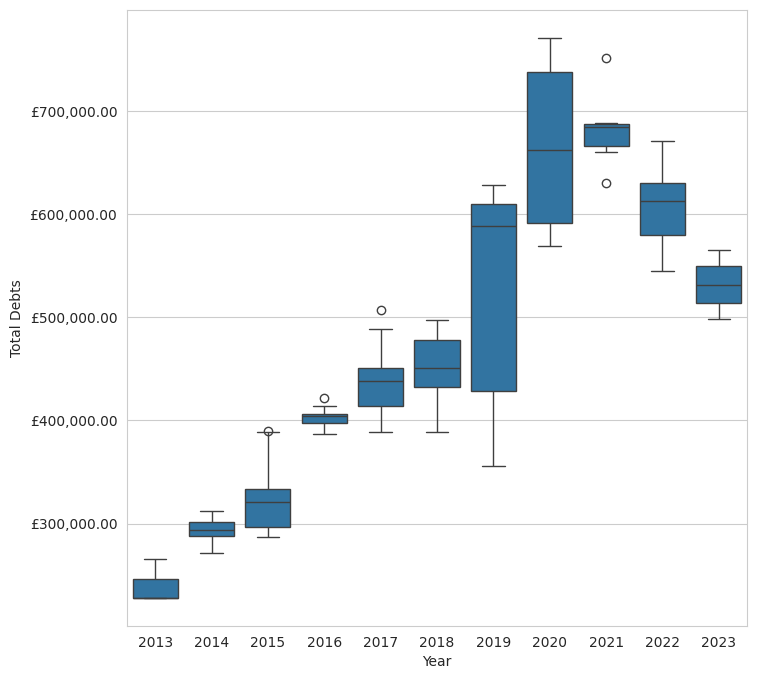

In [38]:
boxplot_annual_averge(data)

In [28]:
data.shape

(84, 14)

In [42]:
# test the plotting func below using one month
monthly_data = data[data['Year'] == 2013]

In [43]:
monthly_data

,Month,Year,LenderA,LenderB,LenderC,LenderD,LenderE,LenderF,LenderG,LenderH,LenderI,LenderJ,LenderK,totalU
datetime,,,,,,,,,,,,,,
2013-10-13,10,2013,74349.0,70109.93,11477.84,4884,0.0,61763.24,0.0,0.0,2442.00,0.0,2981.00,228007.01
2013-11-13,11,2013,73535.0,66083.05,9607.84,5170,0.0,61763.24,2563.0,0.0,2422.09,0.0,6844.09,227988.31
2013-12-10,12,2013,71027.0,93500.00,14300.00,4950,0.0,59400.00,12232.0,0.0,2640.00,0.0,7150.00,265199.00


In [44]:
def year_average_plot(ax, df, title):

    # plotting style
    ax.plot(df.Month, 
            df.totalU, 
            color='black', 
            marker='o', 
            linestyle='-',
            linewidth=2, 
            mfc = 'salmon',
            mec = None,
            markersize=8,
           )
    ax.grid(which='both')
    ax.set_title(f'{title}')
    
    # x-axis formatting
    ax.set_xlim(0, 13)
    ax.xaxis.set_major_locator(
        mpl.ticker.FixedLocator(np.arange(1,13)))
    
    # y-axis formatting
    ax.set_ylim(200000, 800000)
    ax.yaxis.set_major_locator(
        mpl.ticker.FixedLocator(
            [300000, 400000, 500000, 600000, 700000]))
    ax.yaxis.set_major_formatter('£{x:,.2f}')
    ax.yaxis.set_minor_locator(
        mpl.ticker.AutoMinorLocator(n=2))


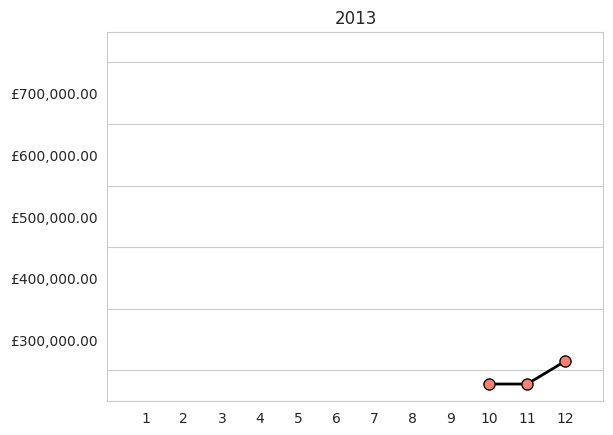

In [45]:
fig, ax = plt.subplots()
year_average_plot(ax, monthly_data, title='2013')

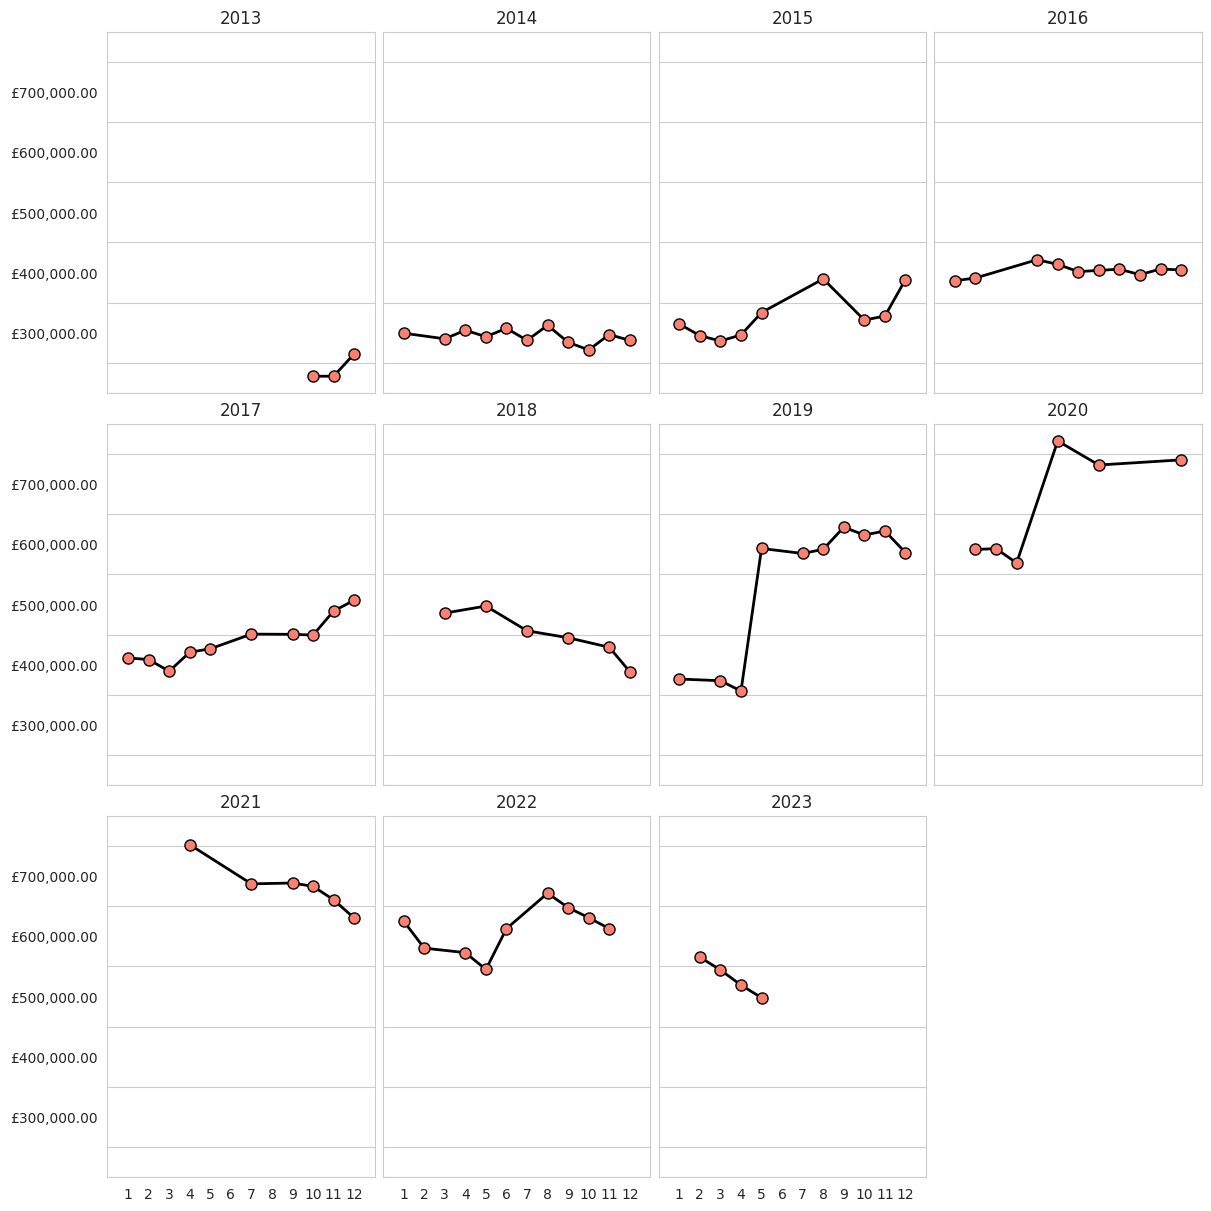

In [46]:
fig, axs = plt.subplots(
    nrows=3, ncols=4, 
    sharex=True, sharey=True,
    layout="constrained",
    figsize=(12, 12))

monthly_data_gen = (data[data['Year'] == year] for year in range(2013, 2024))
year_gen = iter(range(2013, 2024))
    
for row in range(4):
    for col in range(4):
        try: 
            year_average_plot(ax=axs[row, col], df=next(monthly_data_gen), title=next(year_gen))
        except Exception:
            pass
        
fig.delaxes(axs[2][3])
plt.show()

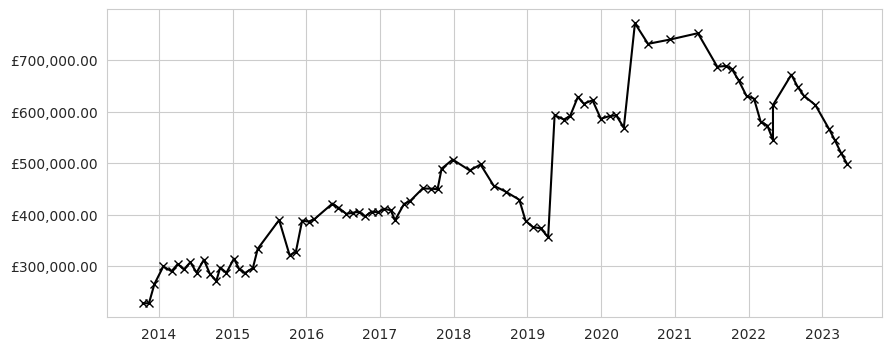

In [47]:
fig, ax  = plt.subplots(figsize=(10, 4))
ax.plot(data.index, data['totalU'], 'k-x')
ax.yaxis.set_major_formatter('£{x:,.2f}')

# Modelling

In [ ]:
## GP modelling

In [48]:
data.head()

,Month,Year,LenderA,LenderB,LenderC,LenderD,LenderE,LenderF,LenderG,LenderH,LenderI,LenderJ,LenderK,totalU
datetime,,,,,,,,,,,,,,
2013-10-13,10,2013,74349.0,70109.93,11477.84,4884,0.0,61763.24,0.0,0.0,2442.00,0.0,2981.00,228007.01
2013-11-13,11,2013,73535.0,66083.05,9607.84,5170,0.0,61763.24,2563.0,0.0,2422.09,0.0,6844.09,227988.31
2013-12-10,12,2013,71027.0,93500.00,14300.00,4950,0.0,59400.00,12232.0,0.0,2640.00,0.0,7150.00,265199.00
2014-01-23,1,2014,0.0,15741.00,14300.00,3300,262944.0,0.00,3168.0,0.0,0.00,0.0,0.00,299453.00
2014-03-05,3,2014,0.0,14850.00,13200.00,3476,254177.0,0.00,4400.0,0.0,0.00,0.0,0.00,290103.00


In [49]:
data.tail()

,Month,Year,LenderA,LenderB,LenderC,LenderD,LenderE,LenderF,LenderG,LenderH,LenderI,LenderJ,LenderK,totalU
datetime,,,,,,,,,,,,,,
2022-11-28,11,2022,28369.0,115775.0,0.0,0,245740.0,22638.0,62084.00,104335.00,14025.0,19800.0,0.0,612766.00
2023-02-05,2,2023,26774.0,108064.0,0.0,0,234740.0,15125.0,57772.00,98703.00,8800.0,15400.0,0.0,565378.00
2023-03-05,3,2023,26202.0,104225.0,0.0,0,231077.0,11352.0,56826.00,95810.00,5500.0,13200.0,0.0,544192.00
2023-04-05,4,2023,25432.0,100375.0,0.0,0,227403.0,7579.0,54618.08,92689.96,0.0,11000.0,0.0,519097.04
2023-05-05,5,2023,24893.0,95975.0,0.0,0,223729.0,3773.0,51876.00,89023.00,0.0,8800.0,0.0,498069.00


In [50]:
# def transform_X(df):
#     """ from date format into numeric format """
#     return (df.index.year + df.index.month / 12).to_numpy().reshape(-1, 1)

In [51]:
def prepare_training_data(df):

    y = data[['totalU']].to_numpy().reshape(-1, 1)
    y = y - y.mean()
    X = (df.index.year + df.index.month / 12).to_numpy().reshape(-1, 1)
    
    # change unit to million
    y = y / 1000_000
    
    return X, y

In [52]:
X, y = prepare_training_data(data)

In [53]:
X.shape

(84, 1)

In [54]:
y.shape

(84, 1)

In [55]:
y[:10]

array([[-0.23742403],
       [-0.23744273],
       [-0.20023204],
       [-0.16597804],
       [-0.17532804],
       [-0.16109404],
       [-0.17180804],
       [-0.15784904],
       [-0.17785804],
       [-0.15291004]])

In [56]:
today = datetime.datetime.now()
current_month = today.year + today.month / 12

In [57]:
# the start month of the observation

start = data.index.min()
start_month = start.year + start.month / 12

In [58]:
# the last month of the observation

last = data.index.max()
last_month = last.year + last.month / 12

In [59]:
X_test = np.linspace(start=start_month, stop=current_month, num=200).reshape(-1, 1)

In [60]:
X_test.shape

(200, 1)

### GP modelling

#### gpflow implementation

In [61]:
import gpflow

In [62]:
# get the zero-mean process
model = gpflow.models.GPR(
    (X, y),
    kernel=gpflow.kernels.SquaredExponential()
    + gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(), period=1.0),
    # likelihood=gpflow.likelihoods.Gaussian(scale=gpflow.functions.Polynomial(degree=2)),
    # noise_variance = 10_000,
)

opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

2023-11-14 22:11:02.656950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 22:11:04.927412: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10771 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0000:04:00.0, compute capability: 3.7
2023-11-14 22:11:04.928842: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10787 MB memory:  -> device: 1, name: Tesla K80, pci bus id: 0000:05:00.0, compute capability: 3.7
2023-11-14 22:11:04.930089: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 10787 MB m

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: -140.61174550233284
        x: [-1.173e-01 -4.115e+00  6.518e-01  1.042e-02 -7.218e+00
            -7.027e+00]
      nit: 40
      jac: [ 6.062e-03 -2.741e-03 -4.476e-03 -2.540e-04  2.639e-04
             7.268e-04]
     nfev: 93
     njev: 93
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

In [63]:
gpflow.utilities.print_summary(model, "notebook")

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.0162
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.63621
GPR.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.00073
GPR.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.69837
GPR.kernel.kernels[1].period,Parameter,Softplus,,True,(),float64,1.07125
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.00089


In [64]:
f_mean, f_var = model.predict_f(X_test, full_cov=False)

In [65]:
f_lower = f_mean - 1.96 * np.sqrt(f_var)
f_upper = f_mean + 1.96 * np.sqrt(f_var)

In [66]:
y_mean, y_var = model.predict_y(X_test)

In [67]:
# f_mean

In [68]:
# y_var

In [69]:
y_lower = y_mean - 1.96 * np.sqrt(y_var)
y_upper = y_mean + 1.96 * np.sqrt(y_var)

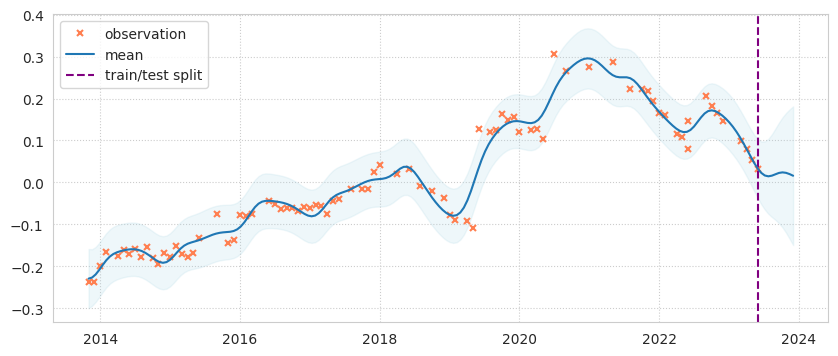

In [70]:
fig, ax = plt.subplots(figsize=(10, 4))

# ground truth
ax.plot(X, y, color="green", label="observation", ls='',
         marker='x', ms=5, mew=1.5,
         mec = 'coral', mfc = 'coral')

# mean function
ax.plot(X_test, f_mean, "-", color="C0", label="mean", zorder=10)

# plt.plot(X_test, y_lower, ".", color="C0", label="Y 95% confidence")
# plt.plot(X_test, y_upper, ".", color="C0")
ax.fill_between(
    X_test[:, 0], y_lower[:, 0], y_upper[:, 0], color="lightblue", alpha=0.2
)

ax.axvline(x=last_month, ymin=0, ymax=1, c='purple', ls='--', label='train/test split')
ax.grid(ls=':')
ax.legend()

#### SciLearn implementation

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [ ]:
kernel = 1 * RBF()
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

In [ ]:
gaussian_process.fit(X, y)

In [ ]:
mean_prediction, std_prediction = gaussian_process.predict(X_test, return_std=True)

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(X, y, color="black", linestyle="dashed", label="gt", marker='.')

plt.plot(X_test, mean_prediction, label="Mean prediction")

plt.fill_between(
    X_test.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)

plt.show()

### Bayesian NN 

In [ ]:
x_train = X
y_train = y

In [ ]:
plt.figure(figsize=(10, 4))
plt.scatter(x_train, y_train, alpha=0.2)
plt.show()

In [ ]:
def build_and_compile_model():
    model = keras.Sequential([
      layers.Dense(64, activation='sigmoid'),
      layers.Dense(128, activation='sigmoid'),
      layers.Dense(1)
    ])

    model.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))
    return model

In [ ]:
DNN_model = build_and_compile_model()

In [ ]:
history = DNN_model.fit(
    x_train,
    y_train,
    # validation_split=0.2,
    verbose=0, 
    batch_size=16,
    epochs=500)

In [ ]:
# plot_loss(history)

In [ ]:
test_predictions = DNN_model.predict(X_test)

In [ ]:
pseudo_train_preds = DNN_model.predict(x_train)

In [ ]:
test_predictions.shape

In [ ]:
# Plot an ensemble of trained probabilistic regressions

plt.scatter(x_train, y_train, marker='.', alpha=0.2, label='data')
plt.scatter(X_test, test_predictions)
plt.scatter(x_train, pseudo_train_preds)
# for _ in range(5):
#     y_model = model_BNN(x_train)
#     y_hat = y_model.mean()
#     y_hat_m2sd = y_hat - 2 * y_model.stddev()
#     y_hat_p2sd = y_hat + 2 * y_model.stddev()
#     if _ == 0:
#         plt.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
#         plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
#         plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
#     else:
#         plt.plot(x_train, y_hat, color='red', alpha=0.8)
#         plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8)
#         plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)        
# plt.legend()
# plt.show()

#### BNN

In [ ]:
# Create probabilistic regression with one hidden layer, weight uncertainty

model_BNN = Sequential([
    tfpl.DenseVariational(units=64,
                          input_shape=(1,),
                          make_prior_fn=sg_prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0],
                          activation='sigmoid'),
    tfpl.DenseVariational(units=64,
                          input_shape=(1,),
                          make_prior_fn=sg_prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0],
                          activation='sigmoid'),
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                          make_prior_fn=sg_prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0]),
    tfpl.IndependentNormal(1)
])

model_BNN.compile(loss=nll, optimizer=RMSprop())

In [ ]:
# # Train the model

# model_BNN.fit(x_train, y_train, epochs=500, verbose=1)
# model_BNN.evaluate(x_train, y_train)

In [ ]:
# Plot an ensemble of trained probabilistic regressions

plt.scatter(x_train, y_train, marker='.', alpha=0.2, label='data')
for _ in range(5):
    y_model = model_BNN(x_train)
    y_hat = y_model.mean()
    y_hat_m2sd = y_hat - 2 * y_model.stddev()
    y_hat_p2sd = y_hat + 2 * y_model.stddev()
    if _ == 0:
        plt.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
    else:
        plt.plot(x_train, y_hat, color='red', alpha=0.8)
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8)
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)        
plt.legend()
plt.show()

In [ ]:
## Machine Learning models in an autoregressive scheme

In [ ]:
# a table showing the accuracy metrics